In [15]:
%matplotlib widget

In [16]:
# ✨ (สำคัญมาก) สำหรับ Jupyter Notebook ให้ Slider ทำงานได้:
# 1. เปิด Terminal/CMD แล้วรัน: pip install ipympl
# 2. ใน Notebook ให้ "สร้าง Cell ใหม่" ไว้บนสุด แล้วรันคำสั่งนี้แค่ครั้งเดียว: %matplotlib widget
# 3. ไปที่เมนู Kernel -> Restart แล้วรันโค้ดทั้งหมดอีกครั้ง

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import os
from pathlib import Path
import pydicom
import datetime
from matplotlib.widgets import Slider # เพิ่มเข้ามาสำหรับ Interactive Viewer

# ====================== Enhanced DICOM Reading for RT Dose ======================
def read_rt_dose_metadata(dicom_file_path):
    """
    อ่าน metadata จาก RT Dose DICOM file (ฟังก์ชันเดิมของคุณ)
    """
    try:
        dcm = pydicom.dcmread(dicom_file_path)
        if hasattr(dcm, 'Modality') and dcm.Modality != 'RTDOSE':
            print(f"⚠️ Warning: This is not RT Dose file (Modality: {dcm.Modality})")
        rows = int(dcm.Rows)
        columns = int(dcm.Columns)
        num_frames = int(dcm.NumberOfFrames) if hasattr(dcm, 'NumberOfFrames') else 1
        pixel_spacing = [float(x) for x in dcm.PixelSpacing] if hasattr(dcm, 'PixelSpacing') else [1.0, 1.0]
        if hasattr(dcm, 'GridFrameOffsetVector'):
            slice_positions = [float(x) for x in dcm.GridFrameOffsetVector]
            slice_thickness = abs(slice_positions[1] - slice_positions[0]) if len(slice_positions) > 1 else 1.0
        else:
            slice_thickness = 1.0
        dose_scaling = float(dcm.DoseGridScaling) if hasattr(dcm, 'DoseGridScaling') else 1.0
        dose_units = dcm.DoseUnits if hasattr(dcm, 'DoseUnits') else 'Gy'
        image_position = [float(x) for x in dcm.ImagePositionPatient] if hasattr(dcm, 'ImagePositionPatient') else None
        image_orientation = [float(x) for x in dcm.ImageOrientationPatient] if hasattr(dcm, 'ImageOrientationPatient') else None
        
        metadata = {
            'original_shape': (num_frames, rows, columns),
            'pixel_spacing': pixel_spacing,
            'slice_thickness': slice_thickness,
            'num_frames': num_frames,
            'matrix_size': (rows, columns),
            'dose_scaling': dose_scaling,
            'dose_units': dose_units,
            'image_position': image_position,
            'image_orientation': image_orientation,
            'dicom_file': dicom_file_path,
            'modality': 'RTDOSE'
        }
        return metadata
    except Exception as e:
        print(f"❌ Error reading RT Dose DICOM: {str(e)}")
        return None

def load_rt_dose_volume(dicom_file_path):
    """
    โหลด RT Dose volume จาก DICOM file และแปลงเป็นหน่วย Gy (ฟังก์ชันเดิมของคุณ)
    """
    try:
        dcm = pydicom.dcmread(dicom_file_path)
        dose_array = dcm.pixel_array.astype(np.float32)
        if hasattr(dcm, 'DoseGridScaling'):
            dose_array *= float(dcm.DoseGridScaling)
        return dose_array
    except Exception as e:
        print(f"❌ Error loading RT Dose volume: {str(e)}")
        return None

# ====================== ✨ NEW Interactive Visualization Function ✨ ======================
def compare_original_vs_processed(original_volume, processed_volume, volume_type='dose'):
    """
    แสดงภาพเปรียบเทียบ Side-by-side พร้อม Slider สำหรับเลื่อนดูสไลซ์
    Includes error handling for Jupyter Notebook environment.
    """
    if original_volume.shape != processed_volume.shape:
        print(f"❌ Cannot visualize: Shapes do not match. GT:{original_volume.shape} vs Pred:{processed_volume.shape}")
        return

    # ✨ IMPORTANT: For this to work in Jupyter, you must install ipympl
    # and run '%matplotlib widget' in a cell beforehand.
    try:
        # พยายามสร้าง Interactive Plot
        from IPython import get_ipython
        if 'ipykernel' not in str(get_ipython()) or 'widget' not in plt.get_backend():
             raise RuntimeError("Interactive backend not active.")

        num_slices = original_volume.shape[0]
        initial_slice = num_slices // 2

        fig, axes = plt.subplots(1, 2, figsize=(14, 7))
        plt.subplots_adjust(bottom=0.25)
        fig.suptitle('Interactive Comparison (Use Slider to Scroll)', fontsize=16)
        vmax = np.percentile(original_volume, 99.9)

        im1 = axes[0].imshow(original_volume[initial_slice, :, :], cmap='hot', vmin=0, vmax=vmax)
        axes[0].set_title(f'Ground Truth (Max: {original_volume.max():.2f} Gy)')
        axes[0].axis('off')
        fig.colorbar(im1, ax=axes[0], shrink=0.8)

        im2 = axes[1].imshow(processed_volume[initial_slice, :, :], cmap='hot', vmin=0, vmax=vmax)
        axes[1].set_title(f'Final Prediction (Max: {processed_volume.max():.2f} Gy)')
        axes[1].axis('off')
        fig.colorbar(im2, ax=axes[1], shrink=0.8)

        ax_slider = plt.axes([0.25, 0.1, 0.65, 0.03])
        slider = Slider(ax=ax_slider, label='Slice', valmin=0, valmax=num_slices - 1, valinit=initial_slice, valstep=1)

        def update(val):
            slice_idx = int(slider.val)
            im1.set_data(original_volume[slice_idx, :, :])
            im2.set_data(processed_volume[slice_idx, :, :])
            fig.canvas.draw_idle()

        # เก็บการอ้างอิงไปยังฟังก์ชัน update เพื่อไม่ให้ถูก garbage collected
        slider.on_changed(update)
        
        # แสดงผล Plot
        plt.show()
        
        # เก็บ slider object ไว้เพื่อป้องกันไม่ให้ถูกลบ
        # ซึ่งเป็นสาเหตุที่ทำให้บางครั้ง slider ไม่ทำงาน
        fig.slider = slider

    except Exception as e:
        # หากเกิด Error (เช่น ยังไม่ได้ติดตั้ง library หรือรัน magic command)
        print("\n--- ⚠️ Interactive Plotting Failed ⚠️ ---")
        print(f"Error: {e}")
        print("This is a Jupyter environment issue, not a code error.")
        print("\nTo enable the interactive slider, please do the following:")
        print("1. In your terminal/console, run: pip install ipympl")
        print("2. In your Jupyter Notebook, create a NEW cell and run this magic command: %matplotlib widget")
        print("3. IMPORTANT: Restart your Jupyter kernel and run this entire code cell again.")
        print("\nDisplaying a static image of the middle slice instead...")
        
        # แสดงภาพนิ่งของสไลซ์ตรงกลางแทน
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        slice_idx = original_volume.shape[0] // 2
        vmax = np.percentile(original_volume, 99.9)
        im1 = axes[0].imshow(original_volume[slice_idx, :, :], cmap='hot', vmin=0, vmax=vmax)
        axes[0].set_title(f'Ground Truth (Max: {original_volume.max():.2f} Gy)')
        fig.colorbar(im1, ax=axes[0], shrink=0.8)
        im2 = axes[1].imshow(processed_volume[slice_idx, :, :], cmap='hot', vmin=0, vmax=vmax)
        axes[1].set_title(f'Final Prediction (Max: {processed_volume.max():.2f} Gy)')
        fig.colorbar(im2, ax=axes[1], shrink=0.8)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

# ====================== Core Post-processing Function (เวอร์ชันเลือกโหมดได้) ======================
def postprocess_with_dicom_reference_simple(
    predicted_volume, dicom_path,
    volume_type='dose', preprocessing_params=None,
    output_path=None, save_npy=True,
    show_visualization=True, compare_with_original=False,
    mode: str = 'soft_mask', # ✨ เพิ่มพารามิเตอร์ mode, default คือวิธีเดิมของคุณ
    blending_weight: float = 0.5
):
    """
    Post-processes using a selectable mode:
    - 'soft_mask': Original method, result is very close to GT shape.
    - 'weighted_blend': Blends the prediction with the GT shape.
    """
    print("="*50)
    print(f"🚀 Running Post-processing with Mode: '{mode}'")
    print("="*50)

    # --- 1. โหลดข้อมูล (เหมือนเดิม) ---
    try:
        gt_dcm = pydicom.dcmread(dicom_path)
        dose_scaling = float(gt_dcm.DoseGridScaling)
        gt_dose_gy = gt_dcm.pixel_array.astype(np.float32) * dose_scaling
        true_max_dose_gy = gt_dose_gy.max()
        raw_prediction = predicted_volume.copy().astype(np.float32)
        print(f"✅ Loaded reference DICOM and prediction.")
    except Exception as e:
        print(f"❌ Error loading data: {e}"); return None

    # --- 2. ปรับขนาด (เหมือนเดิม) ---
    if raw_prediction.shape != gt_dose_gy.shape:
        print(f"\n📐 STEP 1: Resizing Prediction...")
        scale_factors = [gt_dose_gy.shape[i] / raw_prediction.shape[i] for i in range(len(gt_dose_gy.shape))]
        resized_prediction = zoom(raw_prediction, scale_factors, order=1, mode='nearest')
    else:
        resized_prediction = raw_prediction

    # --- 3. ปรับสเกลค่าสูงสุดเบื้องต้น (เหมือนเดิม) ---
    print(f"\n⚙️ STEP 2: Initial Scaling...")
    if resized_prediction.max() > 0:
        scaled_prediction = resized_prediction * (true_max_dose_gy / resized_prediction.max())
    else:
        scaled_prediction = np.zeros_like(resized_prediction)

    # --- ✨✨✨ 4. เลือกใช้ Mask ตามโหมดที่กำหนด ✨✨✨ ---
    print(f"\n🎭 STEP 3: Applying mask with mode='{mode}'...")
    
    # คำนวณ gt_weights สำหรับทั้งสองโหมด
    gt_weights = gt_dose_gy / true_max_dose_gy if true_max_dose_gy > 0 else np.zeros_like(gt_dose_gy)
    
    if mode == 'soft_mask':
        # ใช้วิธีเดิมของคุณโดยตรง
        masked_volume = scaled_prediction * gt_weights
        print("   - Used 'soft_mask' mode. Result will closely match GT shape.")
    elif mode == 'weighted_blend':
        # ใช้วิธีผสม
        blending_weight = np.clip(blending_weight, 0.0, 1.0)
        gt_influenced_dose = scaled_prediction * gt_weights
        masked_volume = ((1 - blending_weight) * scaled_prediction) + (blending_weight * gt_influenced_dose)
        print(f"   - Used 'weighted_blend' mode with weight={blending_weight}.")
    else:
        print(f"   - ⚠️ Unknown mode '{mode}'. Defaulting to 'soft_mask'.")
        masked_volume = scaled_prediction * gt_weights

    # --- 5. Peak Re-normalization (เหมือนเดิม) ---
    print(f"\n✨ STEP 4: Re-normalizing Peak Value...")
    current_max = masked_volume.max()
    if current_max > 0:
        renorm_factor = true_max_dose_gy / current_max
        final_dose_volume = masked_volume * renorm_factor
    else:
        final_dose_volume = masked_volume
        
    final_dose_volume = np.clip(final_dose_volume, 0, None)
    print(f"\n✅ Final Dose Range: [{final_dose_volume.min():.4f}, {final_dose_volume.max():.4f}] Gy")

    # --- 6. บันทึกและแสดงผล (เหมือนเดิม) ---
    if save_npy and output_path:
        np.save(output_path, final_dose_volume)
        print(f"\n💾 Saved final dose to: {output_path}")

    if compare_with_original:
        print("\n📊 Visualizing comparison...")
        compare_original_vs_processed(gt_dose_gy, final_dose_volume)
        
    print("\n✅ Post-processing complete!")
    return final_dose_volume

# ====================== Wrapper and Example Functions (ตามโครงสร้างเดิมของคุณ) ======================
def postprocess_with_rt_dose_reference_safe(predicted_volume, rt_dose_file, 
                                            output_path=None, save_npy=True, 
                                            show_visualization=True, compare_with_original=False, **kwargs):
    print(f"🔒 SAFE RT Dose Postprocessing with reference: {rt_dose_file}")
    if not os.path.exists(rt_dose_file):
        print(f"❌ RT Dose file not found: {rt_dose_file}")
        return None

    # ✨ ดึงค่า mode และ weight จาก kwargs
    mode = kwargs.get('mode', 'soft_mask') # default คือโหมดเดิมของคุณ
    blending_weight = kwargs.get('blending_weight', 0.5)

    return postprocess_with_dicom_reference_simple(
        predicted_volume=predicted_volume,
        dicom_path=rt_dose_file,
        output_path=output_path,
        save_npy=save_npy,
        show_visualization=show_visualization,
        compare_with_original=compare_with_original,
        mode=mode, # ✨ ส่งค่า mode ต่อไป
        blending_weight=blending_weight
    )
def quick_rt_dose_postprocess(prediction_path, rt_dose_path, output_path=None, mode='soft_mask', weight=0.5):
    print(f"⚡ Quick RT Dose Postprocessing (Mode: {mode})")
    print(f"   Prediction: {prediction_path}")
    print(f"   RT Dose ref: {rt_dose_path}")
    
    try:
        predicted_volume = np.load(prediction_path)
        print(f"✅ Loaded prediction: {predicted_volume.shape}")
        
        if output_path is None:
            base_name, _ = os.path.splitext(os.path.basename(prediction_path))
            output_dir = os.path.dirname(prediction_path)
            output_path = os.path.join(output_dir, f"{base_name}_postprocessed.npy")
        
        result = postprocess_with_rt_dose_reference_safe(
            predicted_volume=predicted_volume,
            rt_dose_file=rt_dose_path,
            output_path=output_path,
            save_npy=True,
            show_visualization=False,
            compare_with_original=True,
            mode=mode, # ✨ ส่งค่า mode และ weight
            blending_weight=weight
        )
        
        if result is not None:
            print(f"✅ Quick postprocessing completed: {output_path}")
        
        return result
    except Exception as e:
        print(f"❌ Quick postprocessing failed: {e}")
        return None

## POSTPROCESS

⚡ Quick RT Dose Postprocessing (Mode: soft_mask)
   Prediction: d:\Workhard\OneDrive_1_30-5-2568\PD\BT033\PredictedDose_OriginalSize.npy
   RT Dose ref: d:\Workhard\OneDrive_1_30-5-2568\GT\BT033\RD.1.2.246.352.221.5032954665748044209.16747927485531838618.dcm
✅ Loaded prediction: (143, 512, 512)
🔒 SAFE RT Dose Postprocessing with reference: d:\Workhard\OneDrive_1_30-5-2568\GT\BT033\RD.1.2.246.352.221.5032954665748044209.16747927485531838618.dcm
🚀 Running Post-processing with Mode: 'soft_mask'
✅ Loaded reference DICOM and prediction.

📐 STEP 1: Resizing Prediction...

⚙️ STEP 2: Initial Scaling...

🎭 STEP 3: Applying mask with mode='soft_mask'...
   - Used 'soft_mask' mode. Result will closely match GT shape.

✨ STEP 4: Re-normalizing Peak Value...

✅ Final Dose Range: [0.0000, 569.3223] Gy

💾 Saved final dose to: D:\Workhard\OneDrive_1_30-5-2568\BT033_postprocessed_SAFE.npy

📊 Visualizing comparison...


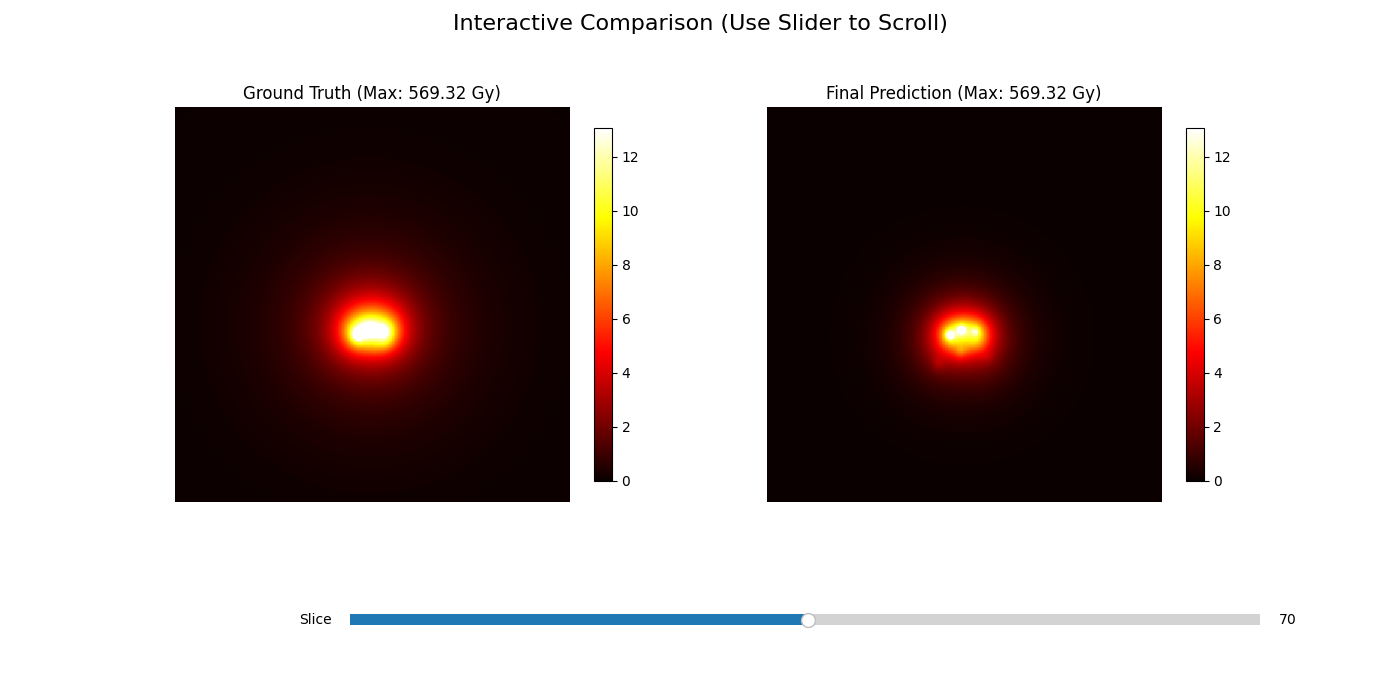


✅ Post-processing complete!
✅ Quick postprocessing completed: D:\Workhard\OneDrive_1_30-5-2568\BT033_postprocessed_SAFE.npy


In [17]:
result = quick_rt_dose_postprocess(
    prediction_path=r"d:\Workhard\OneDrive_1_30-5-2568\PD\BT033\PredictedDose_OriginalSize.npy",
    rt_dose_path=r"d:\Workhard\OneDrive_1_30-5-2568\GT\BT033\RD.1.2.246.352.221.5032954665748044209.16747927485531838618.dcm",
    output_path=r"D:\Workhard\OneDrive_1_30-5-2568\BT033_postprocessed_SAFE.npy"
)

In [18]:
# โหลดและเปรียบเทียบ
import numpy as np
import pydicom

# โหลด prediction result
pred_dose = np.load("d:\Workhard\OneDrive_1_30-5-2568\BT033_postprocessed_SAFE.npy")

# โหลด ground truth DICOM
gt_dicom = pydicom.dcmread("d:\\Workhard\\OneDrive_1_30-5-2568\\GT\\BT033\\RD.1.2.246.352.221.5032954665748044209.16747927485531838618.dcm")
gt_dose = gt_dicom.pixel_array * gt_dicom.DoseGridScaling

# เปรียบเทียบสถิติ
print("=== COMPARISON ===")
print(f"GT Max: {gt_dose.max():.2f} Gy")
print(f"Pred Max: {pred_dose.max():.2f} Gy")
print(f"GT Mean: {gt_dose.mean():.2f} Gy") 
print(f"Pred Mean: {pred_dose.mean():.2f} Gy")

=== COMPARISON ===
GT Max: 569.32 Gy
Pred Max: 569.32 Gy
GT Mean: 0.30 Gy
Pred Mean: 0.10 Gy


In [19]:
# --- โค้ดสำหรับพิสูจน์ไฟล์ .npy ของคุณ (ให้รันใน Cell ใหม่) ---
from scipy.ndimage import zoom
import numpy as np
import pydicom

print("🔬 พิสูจน์ไฟล์ Input .npy...")

# 1. ระบุ Path
GT_DOSE_PATH = r"d:\Workhard\OneDrive_1_30-5-2568\GT\BT033\RD.1.2.246.352.221.5032954665748044209.16747927485531838618.dcm"
PROCESSED_NPY_PATH = r"d:\Workhard\OneDrive_1_30-5-2568\BT033_postprocessed_SAFE.npy"

# 2. โหลดข้อมูลทั้งสอง
gt_dcm = pydicom.dcmread(GT_DOSE_PATH)
gt_dose_gy = gt_dcm.pixel_array.astype(np.float32) * float(gt_dcm.DoseGridScaling)
processed_npy = np.load(PROCESSED_NPY_PATH)

print(f"GT shape: {gt_dose_gy.shape}")
print(f"Post-processed NPY shape: {processed_npy.shape}")

# 3. ✨ Resize NPY ให้มีขนาดเท่ากับ GT เพื่อการเปรียบเทียบเชิงตัวเลขที่ยุติธรรม ✨
# เนื่องจากไฟล์ .ipynb ของคุณก็ทำขั้นตอนนี้เหมือนกัน
scale_factors = [gt_dose_gy.shape[i] / processed_npy.shape[i] for i in range(3)]
resized_npy = zoom(processed_npy, scale_factors, order=1)
print(f"Resized NPY shape for comparison: {resized_npy.shape}")

# 4. คำนวณความแตกต่าง (Mean Absolute Error)
mae = np.mean(np.abs(gt_dose_gy - resized_npy))
print(f"\nค่าความคลาดเคลื่อนเฉลี่ย (MAE) ระหว่าง GT และ NPY (หลังปรับขนาด): {mae:.6f} Gy")

if mae < 1e-3: # ใช้เกณฑ์ที่เล็กมากๆ สำหรับค่า Dose
     print("\n🚨 ผลการตรวจสอบ: ข้อมูลในไฟล์ .npy แทบไม่ต่างจาก Ground Truth เลยหลังปรับขนาด")
     print("   นี่อาจเป็นสาเหตุที่ทำให้ภาพแสดงผลดูเหมือนกัน")
else:
     print("\n✅ ผลการตรวจสอบ: ข้อมูลในไฟล์ .npy แตกต่างจาก Ground Truth อย่างมีนัยสำคัญ")

🔬 พิสูจน์ไฟล์ Input .npy...
GT shape: (140, 133, 133)
Post-processed NPY shape: (140, 133, 133)
Resized NPY shape for comparison: (140, 133, 133)

ค่าความคลาดเคลื่อนเฉลี่ย (MAE) ระหว่าง GT และ NPY (หลังปรับขนาด): 0.205988 Gy

✅ ผลการตรวจสอบ: ข้อมูลในไฟล์ .npy แตกต่างจาก Ground Truth อย่างมีนัยสำคัญ


🚀 Full Workflow: Convert, Verify, Visualize & Package
Found GT DOSE file: RD.1.2.246.352.221.5032954665748044209.16747927485531838618.dcm
📂 Copied 140 CT slices to import folder.
📂 Copied RTSTRUCT file.

💾 Method B: Creating new dose by overwriting template: RD.1.2.246.352.221.5032954665748044209.16747927485531838618.dcm...
✅ Successfully created file: RD.OVERWRITE.BT033_postprocessed_SAFE.dcm


🔬 Running DICOM Pre-import Sanity Check
  1. PatientID Match: ✅ OK
  2. StudyInstanceUID Match: ✅ OK
  3. FrameOfReferenceUID Match: ✅ OK
  4. SeriesInstanceUID is Unique: ✅ OK

✅ All critical UIDs match.


📊 Loading data for 6-Panel Comparison Viewer
✅ All data loaded successfully. Launching viewer...




⚠️ REMINDER: Using Overwrite Method. The new dose file has the same spatial shift as the original GT Dose.
👉 Please import the ENTIRE FOLDER into your TPS: d:\Workhard\OneDrive_1_30-5-2568\Patient33_ForImport


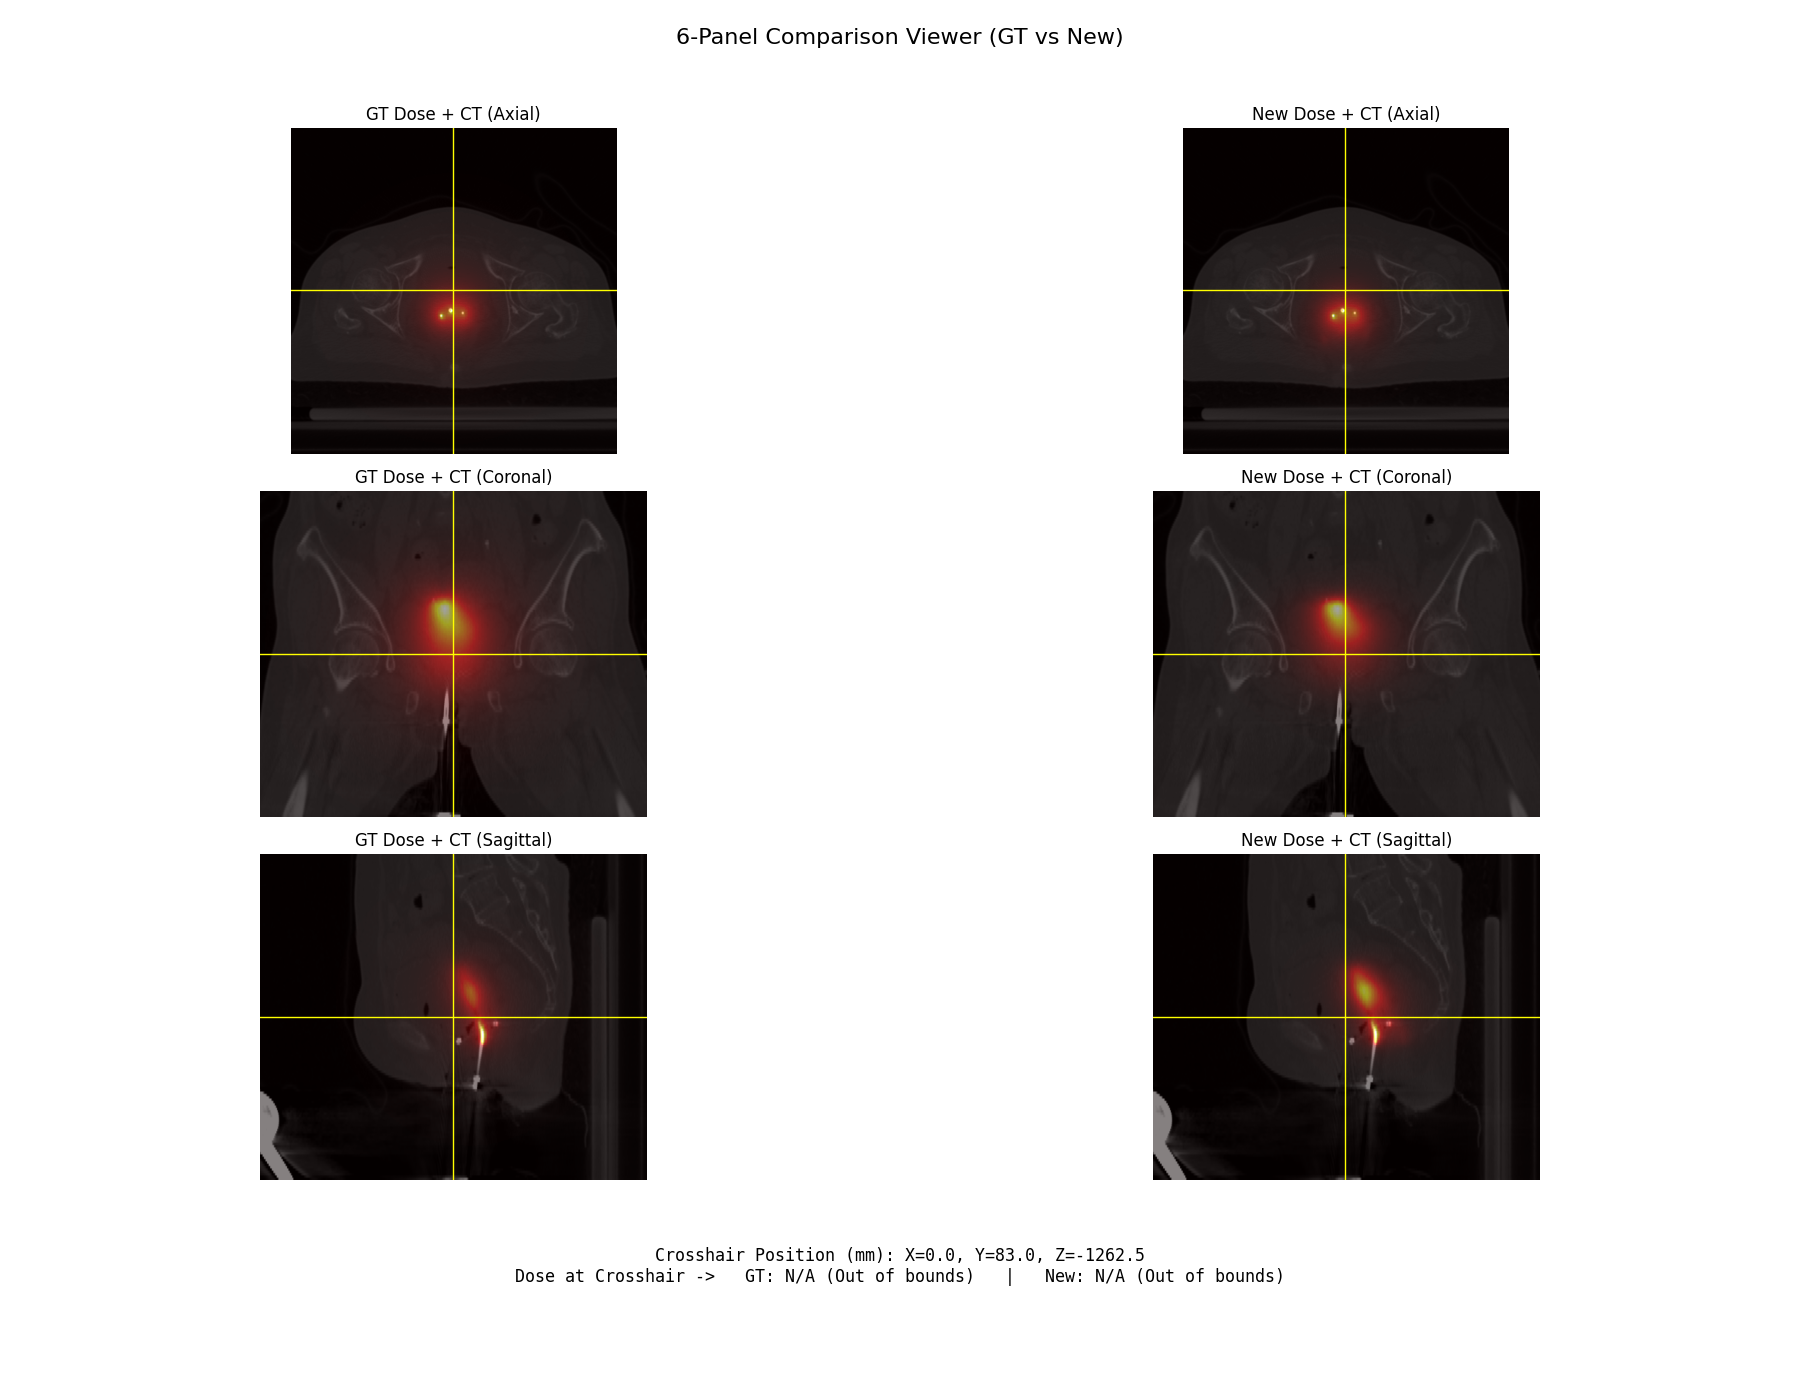

In [20]:
# ✨ (สำคัญมาก) สำหรับ Jupyter Notebook ให้ Slider ทำงานได้:
# 1. รัน 2 คำสั่งนี้ใน Terminal/CMD ก่อน:
#    pip install pydicom matplotlib ipywidgets scipy
#    jupyter nbextension enable --py widgetsnbextension
# 2. ใน Notebook ให้ "สร้าง Cell ใหม่" ไว้บนสุด แล้วรันคำสั่งนี้แค่ครั้งเดียว: %matplotlib widget
# 3. ไปที่เมนู Kernel -> Restart แล้วรันโค้ดทั้งหมดอีกครั้ง

import numpy as np
import pydicom
import os
import shutil
import glob
import datetime
from pydicom.dataset import Dataset, FileDataset
from pydicom.uid import generate_uid
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import ipywidgets as widgets
from ipywidgets import VBox, HBox
from IPython.display import display

# ====================== 1A. ฟังก์ชันสร้าง Dose แบบดั้งเดิม (อิง CT) ======================
def save_unresized_volume_as_dicom(
    dose_volume_gy: np.ndarray,
    reference_ct_slice: pydicom.Dataset,
    output_dicom_path: str,
    dose_pixel_spacing: tuple[float, float],
    dose_slice_thickness: float
) -> tuple[bool, str | None]:
    print(f"\n💾 Method A: Creating new dose aligned to CT...")
    try:
        ref_dcm = reference_ct_slice; file_meta = pydicom.dataset.FileMetaDataset()
        file_meta.MediaStorageSOPClassUID = '1.2.840.10008.5.1.4.1.1.481.2'; file_meta.MediaStorageSOPInstanceUID = generate_uid()
        file_meta.ImplementationClassUID = pydicom.uid.PYDICOM_IMPLEMENTATION_UID; file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian
        ds = FileDataset(None, {}, file_meta=file_meta, preamble=b"\0" * 128)
        ds.PatientName = ref_dcm.PatientName; ds.PatientID = ref_dcm.PatientID
        ds.StudyInstanceUID = ref_dcm.StudyInstanceUID; ds.FrameOfReferenceUID = ref_dcm.FrameOfReferenceUID
        ds.ImagePositionPatient = ref_dcm.ImagePositionPatient; ds.ImageOrientationPatient = ref_dcm.ImageOrientationPatient
        ds.PixelSpacing = [str(dose_pixel_spacing[0]), str(dose_pixel_spacing[1])]
        ds.Rows, ds.Columns = dose_volume_gy.shape[1], dose_volume_gy.shape[2]
        ds.NumberOfFrames = dose_volume_gy.shape[0]
        offsets = [i * dose_slice_thickness for i in range(ds.NumberOfFrames)]
        ds.GridFrameOffsetVector = offsets
        ds.SeriesInstanceUID = generate_uid(); ds.SOPInstanceUID = file_meta.MediaStorageSOPInstanceUID
        now = datetime.datetime.now()
        ds.ContentDate = now.strftime('%Y%m%d'); ds.ContentTime = now.strftime('%H%M%S.%f')
        ds.Modality = 'RTDOSE'; ds.SOPClassUID = file_meta.MediaStorageSOPClassUID
        ds.SeriesDescription = "RTDOSE from Python (Aligned to CT)"; ds.BitsAllocated = 32
        ds.BitsStored = 32; ds.HighBit = 31; ds.PixelRepresentation = 0
        ds.SamplesPerPixel = 1; ds.PhotometricInterpretation = 'MONOCHROME2'
        max_dose = dose_volume_gy.max()
        ds.DoseGridScaling = max_dose / (2**31 - 1) if max_dose > 0 else 1.0
        scaled_pixel_data = (dose_volume_gy / ds.DoseGridScaling).astype(np.uint32)
        ds.PixelData = scaled_pixel_data.tobytes()
        ds.DoseUnits = 'GY'; ds.DoseType = 'PHYSICAL'; ds.DoseSummationType = 'PLAN'
        ds.save_as(output_dicom_path, write_like_original=False)
        print(f"✅ Successfully created file: {os.path.basename(output_dicom_path)}")
        return True, None
    except Exception as e:
        print(f"❌ Error in save_unresized_volume_as_dicom: {e}"); return False, str(e)

# ====================== 1B. ฟังก์ชันใหม่: สร้าง Dose จาก Template (เขียนทับ) ======================
def create_dose_from_template(
    template_dose_path: str,
    new_dose_volume_gy: np.ndarray,
    output_dose_path: str
) -> tuple[bool, str | None]:
    print(f"\n💾 Method B: Creating new dose by overwriting template: {os.path.basename(template_dose_path)}...")
    try:
        ds = pydicom.dcmread(template_dose_path)
        template_shape = (ds.NumberOfFrames, ds.Rows, ds.Columns)
        new_dose_shape = new_dose_volume_gy.shape
        if template_shape != new_dose_shape:
            error_msg = f"Shape mismatch! Template is {template_shape}, new dose is {new_dose_shape}."
            print(f"❌ {error_msg}")
            return False, error_msg
        
        max_dose = new_dose_volume_gy.max()
        ds.DoseGridScaling = max_dose / (2**31 - 1) if max_dose > 0 else 1.0
        scaled_pixel_data = (new_dose_volume_gy / ds.DoseGridScaling).astype(np.uint32)
        ds.PixelData = scaled_pixel_data.tobytes()

        ds.SOPInstanceUID = generate_uid()
        ds.SeriesInstanceUID = generate_uid()
        now = datetime.datetime.now()
        ds.ContentDate = now.strftime('%Y%m%d'); ds.ContentTime = now.strftime('%H%M%S.%f')
        ds.SeriesDescription = "RTDOSE from Python (Template Overwrite)"

        ds.save_as(output_dose_path)
        print(f"✅ Successfully created file: {os.path.basename(output_dose_path)}")
        return True, None
    except Exception as e:
        print(f"❌ Error in create_dose_from_template: {e}")
        return False, str(e)

# ====================== 2. ฟังก์ชันตรวจสอบ DICOM ก่อนนำเข้า TPS ======================
def run_dicom_pre_import_check(ct_series_path: str, new_dose_path: str):
    print("\n\n=========================================================="); print("🔬 Running DICOM Pre-import Sanity Check"); print("==========================================================")
    try:
        new_dcm = pydicom.dcmread(new_dose_path)
        ct_slices = [pydicom.dcmread(f) for f in glob.glob(os.path.join(ct_series_path, "*.dcm")) if pydicom.dcmread(f, stop_before_pixels=True).Modality == 'CT']
        ref_ct = ct_slices[0]
        pid_match = ref_ct.PatientID == new_dcm.PatientID
        study_uid_match = ref_ct.StudyInstanceUID == new_dcm.StudyInstanceUID
        for_uid_match = ref_ct.FrameOfReferenceUID == new_dcm.FrameOfReferenceUID
        series_uid_match = ref_ct.SeriesInstanceUID != new_dcm.SeriesInstanceUID
        print(f"  1. PatientID Match: {'✅ OK' if pid_match else '❌ FAILED'}")
        print(f"  2. StudyInstanceUID Match: {'✅ OK' if study_uid_match else '❌ FAILED'}")
        print(f"  3. FrameOfReferenceUID Match: {'✅ OK' if for_uid_match else '❌ FAILED'}")
        print(f"  4. SeriesInstanceUID is Unique: {'✅ OK' if series_uid_match else '⚠️ WARNING: Series UID is the same as CT'}")
        if pid_match and study_uid_match and for_uid_match: print("\n✅ All critical UIDs match.")
        else: print("\n❌ CRITICAL ERROR: Some UIDs do not match.")
    except Exception as e: print(f"An error occurred during pre-import check: {e}")

# ====================== 3. Class และฟังก์ชันสำหรับแสดงผล MPR Viewer ======================
class ComparisonMPRViewer:
    def __init__(self, ct_volume, ct_slices, gt_dose_volume, gt_dcm, new_dose_volume, new_dcm):
        self.ct_volume = ct_volume
        self.ct_slices = ct_slices
        self.gt_dose_volume = gt_dose_volume
        self.gt_dcm = gt_dcm
        self.new_dose_volume = new_dose_volume
        self.new_dcm = new_dcm
        self.ct_origin = np.array(self.ct_slices[0].ImagePositionPatient, dtype=float)
        self.ct_sp = np.array(self.ct_slices[0].PixelSpacing, dtype=float)
        self.ct_thick = abs(self.ct_slices[1].ImagePositionPatient[2] - self.ct_slices[0].ImagePositionPatient[2]) if len(self.ct_slices) > 1 else 3.0
        self.gt_origin = np.array(self.gt_dcm.ImagePositionPatient, dtype=float)
        self.gt_sp = np.array(self.gt_dcm.PixelSpacing, dtype=float)
        self.gt_thick = abs(self.gt_dcm.GridFrameOffsetVector[1] - self.gt_dcm.GridFrameOffsetVector[0]) if len(self.gt_dcm.GridFrameOffsetVector) > 1 else 3.0
        self.new_origin = np.array(self.new_dcm.ImagePositionPatient, dtype=float)
        self.new_sp = np.array(self.new_dcm.PixelSpacing, dtype=float)
        self.new_thick = abs(self.new_dcm.GridFrameOffsetVector[1] - self.new_dcm.GridFrameOffsetVector[0]) if len(self.new_dcm.GridFrameOffsetVector) > 1 else 3.0
        self.fig = plt.figure(figsize=(18, 14))
        gs = self.fig.add_gridspec(4, 2, height_ratios=[4, 4, 4, 1.2])
        self.ax_gt_axial = self.fig.add_subplot(gs[0, 0])
        self.ax_new_axial = self.fig.add_subplot(gs[0, 1])
        self.ax_gt_coronal = self.fig.add_subplot(gs[1, 0])
        self.ax_new_coronal = self.fig.add_subplot(gs[1, 1])
        self.ax_gt_sagittal = self.fig.add_subplot(gs[2, 0])
        self.ax_new_sagittal = self.fig.add_subplot(gs[2, 1])
        self.ax_info = self.fig.add_subplot(gs[3, :])
        self.fig.suptitle('6-Panel Comparison Viewer (GT vs New)', fontsize=16)
        self.slider_axial = widgets.IntSlider(min=0, max=self.ct_volume.shape[0]-1, value=self.ct_volume.shape[0]//2, description='Axial (Z):', continuous_update=False)
        self.slider_coronal = widgets.IntSlider(min=0, max=self.ct_volume.shape[1]-1, value=self.ct_volume.shape[1]//2, description='Coronal (Y):', continuous_update=False)
        self.slider_sagittal = widgets.IntSlider(min=0, max=self.ct_volume.shape[2]-1, value=self.ct_volume.shape[2]//2, description='Sagittal (X):', continuous_update=False)
        self.slider_axial.observe(self.update, names='value')
        self.slider_coronal.observe(self.update, names='value')
        self.slider_sagittal.observe(self.update, names='value')
        self.update(None)
        display(VBox([self.fig.canvas, HBox([self.slider_axial, self.slider_coronal, self.slider_sagittal])]))

    def update(self, change):
        axial_idx = self.slider_axial.value
        coronal_idx = self.slider_coronal.value
        sagittal_idx = self.slider_sagittal.value
        z_pos = self.ct_origin[2] + axial_idx * self.ct_thick
        y_pos = self.ct_origin[1] + coronal_idx * self.ct_sp[1]
        x_pos = self.ct_origin[0] + sagittal_idx * self.ct_sp[0]
        gt_ax_idx = int(round((z_pos - self.gt_origin[2]) / self.gt_thick))
        gt_co_idx = int(round((y_pos - self.gt_origin[1]) / self.gt_sp[1]))
        gt_sa_idx = int(round((x_pos - self.gt_origin[0]) / self.gt_sp[0]))
        new_ax_idx = int(round((z_pos - self.new_origin[2]) / self.new_thick))
        new_co_idx = int(round((y_pos - self.new_origin[1]) / self.new_sp[1]))
        new_sa_idx = int(round((x_pos - self.new_origin[0]) / self.new_sp[0]))
        all_axes = [self.ax_gt_axial, self.ax_new_axial, self.ax_gt_coronal, self.ax_new_coronal, self.ax_gt_sagittal, self.ax_new_sagittal]
        for ax in all_axes: ax.clear()
        ct_ax_extent = [self.ct_origin[0], self.ct_origin[0] + self.ct_volume.shape[2]*self.ct_sp[0], self.ct_origin[1] + self.ct_volume.shape[1]*self.ct_sp[1], self.ct_origin[1]]
        ct_co_extent = [self.ct_origin[0], self.ct_origin[0] + self.ct_volume.shape[2]*self.ct_sp[0], self.ct_origin[2], self.ct_origin[2] + self.ct_volume.shape[0]*self.ct_thick]
        ct_sa_extent = [self.ct_origin[1], self.ct_origin[1] + self.ct_volume.shape[1]*self.ct_sp[1], self.ct_origin[2], self.ct_origin[2] + self.ct_volume.shape[0]*self.ct_thick]
        gt_ax_extent = [self.gt_origin[0], self.gt_origin[0] + self.gt_dose_volume.shape[2]*self.gt_sp[0], self.gt_origin[1] + self.gt_dose_volume.shape[1]*self.gt_sp[1], self.gt_origin[1]]
        gt_co_extent = [self.gt_origin[0], self.gt_origin[0] + self.gt_dose_volume.shape[2]*self.gt_sp[0], self.gt_origin[2], self.gt_origin[2] + self.gt_dose_volume.shape[0]*self.gt_thick]
        gt_sa_extent = [self.gt_origin[1], self.gt_origin[1] + self.gt_dose_volume.shape[1]*self.gt_sp[1], self.gt_origin[2], self.gt_origin[2] + self.gt_dose_volume.shape[0]*self.gt_thick]
        new_ax_extent = [self.new_origin[0], self.new_origin[0] + self.new_dose_volume.shape[2]*self.new_sp[0], self.new_origin[1] + self.new_dose_volume.shape[1]*self.new_sp[1], self.new_origin[1]]
        new_co_extent = [self.new_origin[0], self.new_origin[0] + self.new_dose_volume.shape[2]*self.new_sp[0], self.new_origin[2], self.new_origin[2] + self.new_dose_volume.shape[0]*self.new_thick]
        new_sa_extent = [self.new_origin[1], self.new_origin[1] + self.new_dose_volume.shape[1]*self.new_sp[1], self.new_origin[2], self.new_origin[2] + self.new_dose_volume.shape[0]*self.new_thick]
        self.ax_gt_axial.imshow(self.ct_volume[axial_idx], cmap='gray', extent=ct_ax_extent, origin='upper')
        if 0 <= gt_ax_idx < self.gt_dose_volume.shape[0]: self.ax_gt_axial.imshow(self.gt_dose_volume[gt_ax_idx], cmap='hot', alpha=0.5, extent=gt_ax_extent, origin='upper')
        self.ax_gt_axial.set_title('GT Dose + CT (Axial)')
        self.ax_gt_coronal.imshow(self.ct_volume[:, coronal_idx, :], cmap='gray', extent=ct_co_extent, origin='lower', aspect='auto')
        if 0 <= gt_co_idx < self.gt_dose_volume.shape[1]: self.ax_gt_coronal.imshow(self.gt_dose_volume[:, gt_co_idx, :], cmap='hot', alpha=0.5, extent=gt_co_extent, origin='lower', aspect='auto')
        self.ax_gt_coronal.set_title('GT Dose + CT (Coronal)')
        self.ax_gt_sagittal.imshow(self.ct_volume[:, :, sagittal_idx], cmap='gray', extent=ct_sa_extent, origin='lower', aspect='auto')
        if 0 <= gt_sa_idx < self.gt_dose_volume.shape[2]: self.ax_gt_sagittal.imshow(self.gt_dose_volume[:, :, gt_sa_idx], cmap='hot', alpha=0.5, extent=gt_sa_extent, origin='lower', aspect='auto')
        self.ax_gt_sagittal.set_title('GT Dose + CT (Sagittal)')
        self.ax_new_axial.imshow(self.ct_volume[axial_idx], cmap='gray', extent=ct_ax_extent, origin='upper')
        if 0 <= new_ax_idx < self.new_dose_volume.shape[0]: self.ax_new_axial.imshow(self.new_dose_volume[new_ax_idx], cmap='hot', alpha=0.5, extent=new_ax_extent, origin='upper')
        self.ax_new_axial.set_title('New Dose + CT (Axial)')
        self.ax_new_coronal.imshow(self.ct_volume[:, coronal_idx, :], cmap='gray', extent=ct_co_extent, origin='lower', aspect='auto')
        if 0 <= new_co_idx < self.new_dose_volume.shape[1]: self.ax_new_coronal.imshow(self.new_dose_volume[:, new_co_idx, :], cmap='hot', alpha=0.5, extent=new_co_extent, origin='lower', aspect='auto')
        self.ax_new_coronal.set_title('New Dose + CT (Coronal)')
        self.ax_new_sagittal.imshow(self.ct_volume[:, :, sagittal_idx], cmap='gray', extent=ct_sa_extent, origin='lower', aspect='auto')
        if 0 <= new_sa_idx < self.new_dose_volume.shape[2]: self.ax_new_sagittal.imshow(self.new_dose_volume[:, :, new_sa_idx], cmap='hot', alpha=0.5, extent=new_sa_extent, origin='lower', aspect='auto')
        self.ax_new_sagittal.set_title('New Dose + CT (Sagittal)')
        for ax in [self.ax_gt_axial, self.ax_new_axial]: ax.axhline(y_pos, color='yellow', lw=1); ax.axvline(x_pos, color='yellow', lw=1)
        for ax in [self.ax_gt_coronal, self.ax_new_coronal]: ax.axhline(z_pos, color='yellow', lw=1); ax.axvline(x_pos, color='yellow', lw=1)
        for ax in [self.ax_gt_sagittal, self.ax_new_sagittal]: ax.axhline(z_pos, color='yellow', lw=1); ax.axvline(y_pos, color='yellow', lw=1)
        self.ax_info.clear()
        gt_dose_val = self.gt_dose_volume[gt_ax_idx, gt_co_idx, gt_sa_idx] if (0<=gt_ax_idx<self.gt_dose_volume.shape[0] and 0<=gt_co_idx<self.gt_dose_volume.shape[1] and 0<=gt_sa_idx<self.gt_dose_volume.shape[2]) else 'N/A'
        new_dose_val = self.new_dose_volume[new_ax_idx, new_co_idx, new_sa_idx] if (0<=new_ax_idx<self.new_dose_volume.shape[0] and 0<=new_co_idx<self.new_dose_volume.shape[1] and 0<=new_sa_idx<self.new_dose_volume.shape[2]) else 'N/A'
        gt_text = f"{gt_dose_val:.4f} Gy" if isinstance(gt_dose_val, (int, float)) else "N/A (Out of bounds)"
        new_text = f"{new_dose_val:.4f} Gy" if isinstance(new_dose_val, (int, float)) else "N/A (Out of bounds)"
        info_text = (f"Crosshair Position (mm): X={x_pos:.1f}, Y={y_pos:.1f}, Z={z_pos:.1f}\n"f"Dose at Crosshair ->   GT: {gt_text}   |   New: {new_text}")
        self.ax_info.text(0.5, 0.5, info_text, ha='center', va='center', fontsize=12, fontfamily='monospace')
        self.ax_info.axis('off')
        for ax in all_axes: ax.axis('off'); ax.set_aspect('equal')
        self.fig.tight_layout(rect=[0, 0.05, 1, 0.96])

def visualize_comparison_mpr_wrapper(ct_series_path, gt_dose_path, new_dose_path):
    print("\n\n=========================================================="); print("📊 Loading data for 6-Panel Comparison Viewer"); print("==========================================================")
    try:
        ct_slices_for_vis = [pydicom.dcmread(f) for f in sorted(glob.glob(os.path.join(ct_series_path, "*.dcm"))) if pydicom.dcmread(f, stop_before_pixels=True).SOPClassUID == '1.2.840.10008.5.1.4.1.1.2']
        if not ct_slices_for_vis: raise ValueError("No valid CT files found in the specified folder.")
        ct_slices_for_vis.sort(key=lambda x: float(x.ImagePositionPatient[2]))
        ct_volume = np.stack([s.pixel_array * s.RescaleSlope + s.RescaleIntercept for s in ct_slices_for_vis], axis=0)
        gt_dcm = pydicom.dcmread(gt_dose_path)
        gt_dose_volume = gt_dcm.pixel_array.astype(np.float32) * float(gt_dcm.DoseGridScaling)
        new_dcm = pydicom.dcmread(new_dose_path)
        new_dose_volume = new_dcm.pixel_array.astype(np.float32) * float(new_dcm.DoseGridScaling)
        print("✅ All data loaded successfully. Launching viewer...")
        ComparisonMPRViewer(ct_volume, ct_slices_for_vis, gt_dose_volume, gt_dcm, new_dose_volume, new_dcm)
    except Exception as e:
        print(f"❌ Error during data loading for visualization: {e}")

# =========================== 4. MAIN WORKFLOW (มีสวิตช์เลือกวิธี) ===================================
if __name__ == '__main__':
    # --- 1. ตั้งค่า Path และ สวิตช์เลือกวิธี ---
    PROCESSED_NPY_PATH = r"d:\Workhard\OneDrive_1_30-5-2568\BT033_postprocessed_SAFE.npy"
    GT_CT_SERIES_PATH = r"d:\Workhard\OneDrive_1_30-5-2568\GT-Real\BT033"
    GT_OTHER_FILES_PATH = r"d:\Workhard\OneDrive_1_30-5-2568\GT\BT033"
    TPS_IMPORT_FOLDER_NAME = "Patient33_ForImport"

    # ✨✨✨ --- สวิตช์เลือกวิธีสร้างไฟล์ --- ✨✨✨
    # True  = ใช้วิธีเขียนทับ (Method B) -> อาจจะ Import ง่าย แต่ตำแหน่ง Dose จะเพี้ยนตามไฟล์เก่า
    # False = ใช้วิธีสร้างใหม่ (Method A) -> ตำแหน่ง Dose ถูกต้อง 100% แต่อาจต้องใช้ Dummy Plan ใน TPS
    USE_OVERWRITE_METHOD = True # <--- ปรับค่าตรงนี้
    # ✨✨✨ --------------------------------- ✨✨✨
    
    # --- 2. เริ่ม Workflow ---
    print("="*50); print("🚀 Full Workflow: Convert, Verify, Visualize & Package"); print("="*50)
    
    try:
        gt_dose_files = [f for f in glob.glob(os.path.join(GT_OTHER_FILES_PATH, "*.dcm")) if pydicom.dcmread(f, stop_before_pixels=True).Modality == 'RTDOSE']
        if not gt_dose_files: raise FileNotFoundError("No RTDOSE file found.")
        GT_DOSE_DICOM_PATH = gt_dose_files[0]
        print(f"Found GT DOSE file: {os.path.basename(GT_DOSE_DICOM_PATH)}")
    except Exception as e:
        print(f"❌ Error finding GT DOSE file: {e}"); exit()

    base_output_dir = os.path.dirname(PROCESSED_NPY_PATH)
    tps_import_path = os.path.join(base_output_dir, TPS_IMPORT_FOLDER_NAME)
    if os.path.exists(tps_import_path): shutil.rmtree(tps_import_path)
    os.makedirs(tps_import_path)

    valid_ct_slices = [pydicom.dcmread(f) for f in sorted(glob.glob(os.path.join(GT_CT_SERIES_PATH, "*.dcm"))) if pydicom.dcmread(f, stop_before_pixels=True).SOPClassUID == '1.2.840.10008.5.1.4.1.1.2']
    if not valid_ct_slices: print(f"❌ FATAL ERROR: No CT images found."); exit()
    valid_ct_slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    first_for_uid = valid_ct_slices[0].FrameOfReferenceUID
    if not all(s.FrameOfReferenceUID == first_for_uid for s in valid_ct_slices): print("❌ CRITICAL ERROR: Inconsistent FOR UID in CT series."); exit()
    for ct_slice in valid_ct_slices: shutil.copy(ct_slice.filename, tps_import_path)
    print(f"📂 Copied {len(valid_ct_slices)} CT slices to import folder.")

    try:
        rs_files = [f for f in glob.glob(os.path.join(GT_OTHER_FILES_PATH, "*.dcm")) if pydicom.dcmread(f, stop_before_pixels=True).Modality == 'RTSTRUCT']
        if rs_files and pydicom.dcmread(rs_files[0]).ReferencedFrameOfReferenceSequence[0].FrameOfReferenceUID == first_for_uid:
            shutil.copy(rs_files[0], tps_import_path); print(f"📂 Copied RTSTRUCT file.")
    except Exception: pass

    # --- 3. สร้างไฟล์ Dose ใหม่โดยใช้วิธีที่เลือก ---
    new_dose_gy = np.load(PROCESSED_NPY_PATH)
    file_prefix = 'RD.OVERWRITE' if USE_OVERWRITE_METHOD else 'RD.ALIGNED'
    final_dicom_output_path = os.path.join(tps_import_path, f"{file_prefix}.{os.path.basename(PROCESSED_NPY_PATH).split('.')[0]}.dcm")
    
    if USE_OVERWRITE_METHOD:
        conversion_success, error = create_dose_from_template(
            template_dose_path=GT_DOSE_DICOM_PATH,
            new_dose_volume_gy=new_dose_gy,
            output_dose_path=final_dicom_output_path
        )
    else:
        ref_gt_dcm_for_meta = pydicom.dcmread(GT_DOSE_DICOM_PATH, stop_before_pixels=True)
        AUTO_PIXEL_SPACING = tuple(ref_gt_dcm_for_meta.PixelSpacing)
        AUTO_SLICE_THICKNESS = abs(ref_gt_dcm_for_meta.GridFrameOffsetVector[1] - ref_gt_dcm_for_meta.GridFrameOffsetVector[0])
        
        conversion_success, error = save_unresized_volume_as_dicom(
            dose_volume_gy=new_dose_gy, 
            reference_ct_slice=valid_ct_slices[0],
            output_dicom_path=final_dicom_output_path, 
            dose_pixel_spacing=AUTO_PIXEL_SPACING,
            dose_slice_thickness=AUTO_SLICE_THICKNESS
        )
    
    # --- 4. ตรวจสอบและแสดงผล (ทำงานได้กับทั้งสองวิธี) ---
    if conversion_success:
        run_dicom_pre_import_check(ct_series_path=tps_import_path, new_dose_path=final_dicom_output_path)
        gt_dose_dest_path = os.path.join(tps_import_path, os.path.basename(GT_DOSE_DICOM_PATH))
        shutil.copy(GT_DOSE_DICOM_PATH, gt_dose_dest_path)
        
        visualize_comparison_mpr_wrapper(
            ct_series_path=tps_import_path, 
            gt_dose_path=gt_dose_dest_path,
            new_dose_path=final_dicom_output_path
        )

    print("\n\n==========================================================")
    if USE_OVERWRITE_METHOD:
        print("⚠️ REMINDER: Using Overwrite Method. The new dose file has the same spatial shift as the original GT Dose.")
    else:
        print("✅ Using Align-to-CT Method. The new dose file is spatially correct.")
    print(f"👉 Please import the ENTIRE FOLDER into your TPS: {tps_import_path}")
    print("==========================================================")

In [21]:
import pydicom
import os
import glob
import numpy as np

# ======================= ✨ ADVANCED DIAGNOSTIC TOOL ✨ =======================
#      ใส่ Path ของไฟล์ทั้งหมดที่คุณต้องการตรวจสอบ: ต้นทาง (GT) และผลลัพธ์ (New)
# ============================================================================
CT_SERIES_PATH    = r"d:\Workhard\OneDrive_1_30-5-2568\GT\BT033_CT"
GT_DOSE_PATH      = r"d:\Workhard\OneDrive_1_30-5-2568\GT\BT033\RD.1.2.246.352.221.5032954665748044209.16747927485531838618.dcm"

# --- ใส่ Path ของไฟล์ที่สร้างขึ้นใหม่ตรงนี้ ---
# ปกติจะอยู่ในโฟลเดอร์ PatientXX_ForImport...
NEW_DOSE_PATH     = r"d:\Workhard\OneDrive_1_30-5-2568\Patient33_ForImport\RD.OVERWRITE.BT033_postprocessed_SAFE.dcm" 

def get_file_info(file_path, is_ct=False):
    """ดึงข้อมูล UID และ Spatial ที่สำคัญจากไฟล์ DICOM"""
    try:
        if is_ct:
            dcm_files = sorted(glob.glob(os.path.join(file_path, "*.dcm")), key=lambda x: pydicom.dcmread(x).ImagePositionPatient[2])
            ds_first = pydicom.dcmread(dcm_files[0])
            ds_last = pydicom.dcmread(dcm_files[-1])
            z_spacing = abs(ds_first.ImagePositionPatient[2] - pydicom.dcmread(dcm_files[1]).ImagePositionPatient[2]) if len(dcm_files) > 1 else 0
            dimensions = f"{ds_first.Rows}x{ds_first.Columns}x{len(dcm_files)}"
            ds = ds_first
        else:
            if not (file_path and os.path.exists(file_path)): return None, None
            ds = pydicom.dcmread(file_path)
            z_spacing = abs(ds.GridFrameOffsetVector[1] - ds.GridFrameOffsetVector[0]) if len(ds.GridFrameOffsetVector) > 1 else 0
            dimensions = f"{ds.Rows}x{ds.Columns}x{ds.NumberOfFrames}"

        uids = {
            "PatientID": ds.PatientID,
            "StudyInstanceUID": ds.StudyInstanceUID,
            "FrameOfReferenceUID": ds.FrameOfReferenceUID
        }
        spatial = {
            "Origin (IPP)": np.round(ds.ImagePositionPatient, 2),
            "Orientation (IOP)": np.round(ds.ImageOrientationPatient, 4),
            "XY Spacing (mm)": np.round(ds.PixelSpacing, 2),
            "Z Spacing (mm)": np.round(z_spacing, 2),
            "Dimensions": dimensions
        }
        return uids, spatial
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return None, None

def run_advanced_check():
    print("="*80)
    print("🔬 Running Advanced UID & Spatial Alignment Check...")
    print("="*80)

    ct_uids, ct_spatial = get_file_info(CT_SERIES_PATH, is_ct=True)
    gt_dose_uids, gt_dose_spatial = get_file_info(GT_DOSE_PATH)
    new_dose_uids, new_dose_spatial = get_file_info(NEW_DOSE_PATH)

    if not ct_uids: print("❌ CT data could not be read. Aborting."); return
    if not new_dose_uids: print("❌ New Dose file could not be read. Aborting."); return

    # --- 1. ตารางเปรียบเทียบ UIDs ---
    print("\n--- [UIDs COMPARISON] ---")
    print(f"{'UID Type':<22} | {'CT Series':<20} | {'New Dose':<20} | {'GT Dose'}")
    print("-"*90)
    for uid_type in ["PatientID", "StudyInstanceUID", "FrameOfReferenceUID"]:
        ct_val = ct_uids.get(uid_type, "N/A")
        new_val = new_dose_uids.get(uid_type, "N/A")
        gt_val = gt_dose_uids.get(uid_type, "N/A") if gt_dose_uids else "N/A"
        print(f"{uid_type:<22} | {ct_val:<20} | {new_val:<20} | {gt_val}")
    
    # --- 2. ตารางเปรียบเทียบ SPATIAL INFO ---
    print("\n\n--- [SPATIAL INFO COMPARISON] ---")
    print(f"{'Parameter':<22} | {'CT Series':<30} | {'New Dose':<30} | {'GT Dose'}")
    print("-"*110)
    for param in ["Origin (IPP)", "Orientation (IOP)", "XY Spacing (mm)", "Z Spacing (mm)", "Dimensions"]:
        ct_val = str(ct_spatial.get(param, "N/A"))
        new_val = str(new_dose_spatial.get(param, "N/A"))
        gt_val = str(gt_dose_spatial.get(param, "N/A")) if gt_dose_spatial else "N/A"
        print(f"{param:<22} | {ct_val:<30} | {new_val:<30} | {gt_val}")

    # --- 3. สรุปผลการตรวจสอบที่สำคัญ ---
    print("\n\n--- [CRITICAL ALIGNMENT CHECKS (CT vs New Dose)] ---")
    all_ok = True
    # Check UIDs
    for uid_type in ["PatientID", "StudyInstanceUID", "FrameOfReferenceUID"]:
        match = ct_uids[uid_type] == new_dose_uids[uid_type]
        print(f"UID Match - {uid_type:<20}: {'✅ MATCH' if match else '❌ MISMATCH'}")
        if not match: all_ok = False
    
    # Check Critical Spatial Tags
    print("-"*40)
    ipp_match = np.allclose(ct_spatial["Origin (IPP)"], new_dose_spatial["Origin (IPP)"])
    iop_match = np.allclose(ct_spatial["Orientation (IOP)"], new_dose_spatial["Orientation (IOP)"])
    print(f"{'Spatial Match - Origin (IPP):':<35} {'✅ MATCH' if ipp_match else '❌ MISMATCH'}")
    print(f"{'Spatial Match - Orientation (IOP):':<35} {'✅ MATCH' if iop_match else '❌ MISMATCH'}")
    if not (ipp_match and iop_match): all_ok = False

    print("\n--- FINAL CONCLUSION ---")
    if all_ok:
        print("✅✅✅ Success! Your new dose file is perfectly aligned with the CT series.")
        print("If an import error still occurs, the issue is likely on the TPS side (workflow, cache, or requires a dummy plan).")
    else:
        print("❌❌❌ CRITICAL ERROR: Your new dose file IS NOT correctly aligned with the CT.")
        print("Please review the MISMATCH results above to identify the problem.")


run_advanced_check()

🔬 Running Advanced UID & Spatial Alignment Check...

--- [UIDs COMPARISON] ---
UID Type               | CT Series            | New Dose             | GT Dose
------------------------------------------------------------------------------------------
PatientID              | Thesis_Nawarat_BT033 | Thesis_Nawarat_BT033 | Thesis_Nawarat_BT033
StudyInstanceUID       | 1.2.246.352.221.5583200468916638306.3021783925382637187 | 1.2.246.352.221.5583200468916638306.3021783925382637187 | 1.2.246.352.221.5583200468916638306.3021783925382637187
FrameOfReferenceUID    | 1.2.246.352.221.5389856711496415164.2838135394727005077 | 1.2.246.352.221.5389856711496415164.2838135394727005077 | 1.2.246.352.221.5389856711496415164.2838135394727005077


--- [SPATIAL INFO COMPARISON] ---
Parameter              | CT Series                      | New Dose                       | GT Dose
--------------------------------------------------------------------------------------------------------------
Origin (IPP)       